In [1]:
#Importing all the libraries
using SpecialFunctions
using LinearAlgebra
using DataFrames
using StatsPlots
using Plots.Measures
using ProgressMeter
using CSV
using Combinatorics
using MultinomialSeries
theme(:dao)
ProgressMeter.ijulia_behavior(:clear)

function scurve(x)  #Function for an S shaped curve, used inside survival function
    return 1/(1 + exp(-11 * (x - 0.5)))
end

int(x) = floor(Int, round(x))

int (generic function with 1 method)

In [2]:
global DOMINANT = false        #Switch between 1 being dominant or recessive
SHAPE = "linear"                  #Shape of survival function

P = Dict{String,Any}(
    "pm" => 0.01,       #Proportion of 1 for male locus
    "pf" => 0.01,       #Proportion of 1 for female locus
    "B" => 20,          #Eggs laid by non functionender females
    "c_f" => 0.65,          #Eggs laid by defender females
    "c_m" => 0.65,         #Disadvantege for defender males
    "u" => 0.1,         #Probability of female staying unmated
    "r" => 0.5          #Ratio of males in a female male mating
    )

function s(d, use = "exp")      #Probability of survival given the proportion of functionenders in the offsprings
    if use == "linear"
        return d * (0.9 - 0.1) + 0.1
    elseif use == "expinv"
        return ((exp(-d * 2.5) - exp(0))/(exp(-1 * 2.5) - exp(0))) * (0.9 - 0.1) + 0.1
    elseif use == "exp"
        return ((exp(2.5*d) - exp(0))/(exp(2.5) - exp(0))) * (0.9 - 0.1) + 0.1
    elseif use == "s"
        return 0.8/(1 + exp(-11*(d - 0.5))) + 0.1#((scurve(d) - scurve(0)) / (scurve(1) - scurve(0))) * (0.9 - 0.1) + 0.1
    elseif use == "relu"
        return minimum(0.9, maximum(0.1, d^1.5))
    end
end

s (generic function with 2 methods)

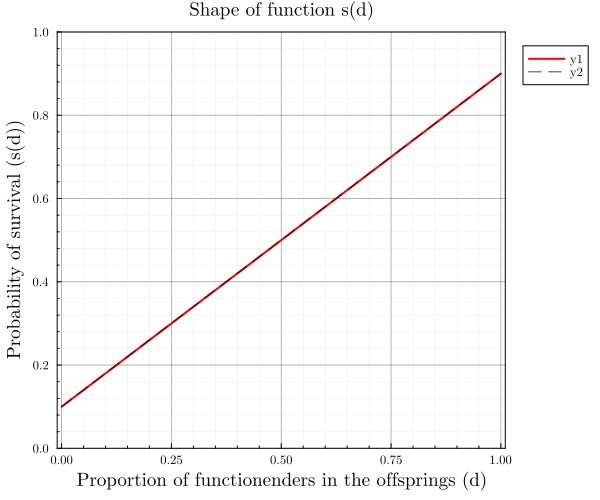

In [3]:
#Plotting the shape of survival function
d = range(0, stop=1, length=101)
plot(d, s.(d, SHAPE), lw = 2, lc=:red, size = (600,500))
plot!(d, range(0.1, stop=0.9, length=101), linestyle=:dash, color=:black, alpha=0.5, lw = 1.5)
xlims!(-0.01,1.01)
ylims!(0.0, 1)
xlabel!("Proportion of functionenders in the offsprings (d)")
ylabel!("Probability of survival (s(d))")
title!("Shape of function s(d)")

In [4]:
#Modular functions for different loops
function F(u, f, m, c, S) #Calculating the overall numberr of offsprings
    return u * f * m * c * S
end

function S1(c, r)
    k = collect(0:c)
    S = sum(binomial.(c, k) .* (((r).^k).*((1-r).^(c.-k))) .* s.(any(isnan, k/c) ? 0 : k/c, SHAPE) .* k)
    return S
end

function S2(c, r1, r2, case = 1)
    if case == 1
        S = 0
        for k in 0:c
            mul1 = binomial.(c, k) * (((r1).^k).*((1-r1).^(c-k)))
            m = collect(0:k)
            Sm = sum(binomial.(k, m) .* (((r2).^m).*((1-r2).^(k.-m))) .* s.(any(isnan, m/c) ? 0 : m/c, SHAPE))
            S +=  mul1 * Sm
        end
    elseif case == 2
        S = 0
        for k in 0:c
            mul1 = binomial.(c, k) * (((r1).^k).*((1-r1).^(c-k)))
            m = collect(0:k)
            Sm = sum(binomial.(k, m) .* (((r2).^m).*((1-r2).^(k.-m))) .* s.(any(isnan, (m .+ (c - k))/c) ? 0 : (m .+ (c - k))/c, SHAPE))
            S +=  mul1 * Sm
        end
    end
    return S
end

function S3(c, r1, r2, r3)
    S = 0
    for k in 0:c
        mul1 = binomial.(c, k) * (((r1).^k).*((1-r1).^(c-k)))
        for m in 0:k
            mul2 = binomial.(k, m) * (((r2).^m).*((1-r2).^(k-m)))
            f = collect(0:c-k)
            Sf = sum(binomial.(c-k, f) .* (((r3).^f).*((1-r3).^(c-k.-f))) .* s.(any(isnan, (f.+m)/c) ? 0 : (f.+m)/c, SHAPE) .* f)
            S += mul1 * mul2 * Sf
        end
    end
    return S
end

S3 (generic function with 1 method)

In [5]:
function calc_surv(dist, C, r, def_index)
    prob = MultinomialSeries.multinomial(tuple(dist...)) * prod(r .^ dist) # Multinomial Probability of this brood composition
    return prob * s(any(isnan, sum(dist[begin:1:def_index])/C) ? 0 : sum(dist[begin:1:def_index])/C, SHAPE) #Multiplied by the survival chance
end

function calc_combinations(C, n_var, def_id, r)
    comb = [] #Initializing an empty array
    func = x -> x .* calc_surv(x, C, r, def_id) #Defining function to perform on the list of all combinations
    comb = vcat(sum(map(func,collect(Combinatorics.multiexponents(n_var, C))), dims = 1)...) #For each combination calculate the survival and multiply with each element of that combination and add all the results
    return comb
end

calc_combinations (generic function with 1 method)

In [9]:
P["comb_2_dom"] = calc_combinations(int((1-P["c_f"])*P["B"]), 2, 1, [0.5, 0.5])

8-element Vector{Any}:
 [0.0, 0.0054687500000000005]
 [0.04921875, 0.0]
 [0.01171875, 0.0703125]
 [0.2578125, 0.04296875]
 [0.1078125, 0.26953125]
 [0.55078125, 0.22031250000000002]
 [0.36328125, 0.484375]
 [0.609375, 0.45703125]

In [6]:
#Calculating combinations
P["comb_f01"] = DOMINANT ? calc_combinations(int((1-P["c_f"])*P["B"]), 2, 1, [0.5, 0.5]) : calc_combinations(P["B"], 2, 1, [0.5, 0.5])

P["comb_f00m0"] = calc_combinations(P["B"], 2, 0, [1-P["r"], P["r"]])

P["comb_f11m1"] = calc_combinations(int((1-P["c_f"])*P["B"]), 2, 2, [1-P["r"], P["r"]])

P["comb_f00m1"] = DOMINANT ? calc_combinations(P["B"], 2, 1, [1 - P["r"], P["r"]]) : calc_combinations(P["B"], 2, 0, [1 - P["r"], P["r"]])

P["comb_f11m0"] = DOMINANT: calc_combinations(int((1-P["c_f"])*P["B"]), 2, 2, [P["r"], 1 - P["r"]]) : calc_combinations(int((1-P["c_f"])*P["B"]), 2, 1, [P["r"], 1 - P["r"]])

P["comb_f01m0"] = DOMINANT ? calc_combinations(int((1-P["c_f"])*P["B"]), 4, 2, [P["r"] * 0.5, (1 - P["r"]) * 0.5, P["r"] * 0.5, (1 - P["r"]) * 0.5]) : calc_combinations(P["B"], 4, 1, [P["r"] * 0.5, (1 - P["r"]) * 0.5, P["r"] * 0.5, (1 - P["r"]) * 0.5])

P["comb_f01m1"] = DOMINANT ? calc_combinations(int((1-P["c_f"])*P["B"]), 4, 3, [(1 - P["r"]) * 0.5, P["r"] * 0.5, (1 - P["r"]) * 0.5, P["r"] * 0.5]) : calc_combinations(P["B"], 4, 2, [(1 - P["r"]) * 0.5, P["r"] * 0.5, (1 - P["r"]) * 0.5, P["r"] * 0.5])



MethodError: MethodError: no method matching (::Colon)(::Bool, ::Vector{Float64}, ::Vector{Float64})

Closest candidates are:
  (::Colon)(::T, ::Any, !Matched::T) where T<:Real
   @ Base range.jl:45
  (::Colon)(::A, ::Any, !Matched::C) where {A<:Real, C<:Real}
   @ Base range.jl:10
  (::Colon)(::T, ::Any, !Matched::T) where T
   @ Base range.jl:44
  ...


In [7]:
#Defining all interactions and offsprings
#Non matings
function f00(P) #Results: M0 (1)
    m0 = F(P["u"], P["f00"], 1, P["B"], s(0, SHAPE))   
    return m0
end

function f01(P) #Results: M0 (0.5), M1 (0.5)
    off = P["comb_f01"]
    m1 = off[1] * P["u"] * P["f01"]
    m0 = off[2] * P["u"] * P["f01"]
    return m1, m0
end

function f11(P) #Results M1 (1)
    m1 = F(P["u"], P["f11"], 1, int((1-P["c_f"])*P["B"]), s(1, SHAPE))
    return m1
end


#Matings
function f00m0(P) #Results: F00 (1-r), M0 (r)
    off = P["comb_f00m0"]
    f00 = off[1] * (1-P["u"]) * P["f00"] * P["m0"]
    m0 = off[2] * (1-P["u"]) * P["f00"] * P["m0"]
    return f00, m0
end

function f11m1(P) #Results: F11 (1-r), M1 (r)
   off =  P["comb_f11m1"]
   f11 = off[1] * (1-P["u"]) * P["f11"] * P["m1"]
   m1 = off[2] * (1-P["u"]) * P["f11"] * P["m1"]
   return f11, m1
end

function f00m1(P) #Results: F01 (1-r), M0 (r)
    off = P["comb_f00m1"]
    f01 = off[1] * (1-P["u"]) * P["f00"] * P["m1"]
    m0 = off[2] * (1-P["u"]) * P["f00"] * P["m1"]
    return f01, m0
end

function f11m0(P) #Results: F01 (1-r), M1(r)
    off = P["comb_f11m0"]
    m1 = off[1] * (1-P["u"]) * P["f11"] * P["m0"]
    f01 = off[2] * (1-P["u"]) * P["f11"] * P["m0"]
    return f01, m1
end

function f01m0(P) #Results: F01 (1-r * 0.5), F00 (1-r * 0.5), M1 (r * 0.5), M0 (r * 0.5)
    off = P["comb_f01m0"]
    m1 = off[1] * (1-P["u"]) * P["f01"] * P["m0"]
    f01 = off[2] * (1-P["u"]) * P["f01"] * P["m0"]
    m0 = off[3] * (1-P["u"]) * P["f01"] * P["m0"]
    f00 = off[4] * (1-P["u"]) * P["f01"] * P["m0"]
    return f01, m1, f00, m0
end

function f01m1(P) #Results: F01 (1-r * 0.5), F11 (1-r * 0.5), M1 (r * 0.5), M0 (r * 0.5)
    off = P["comb_f01m1"]
    f11 = off[1] * (1-P["u"]) * P["f01"] * P["m1"]
    m1 = off[2] * (1-P["u"]) * P["f01"] * P["m1"]
    f01 = off[3] * (1-P["u"]) * P["f01"] * P["m1"]
    m0 = off[4] * (1-P["u"]) * P["f01"] * P["m1"]
    return f11, m1, f01, m0
end

f01m1 (generic function with 1 method)

In [5]:
#Defining all interactions and offsprings
#Non matings
function f00(P) #Results: M0 (1)    
    return F(P["u"], P["f00"], 1, P["B"], s(0, SHAPE))
end

function f01(P) #Results: M0 (0.5), M1 (0.5)
    return F(P["u"], P["f01"], 1, DOMINANT ? int((1-P["c_f"])*P["B"]) : P["B"], S1(DOMINANT ? int((1-P["c_f"])*P["B"]) : P["B"], 0.5))
end

function f11(P) #Results M1 (1)
    return F(P["u"], P["f11"], 1, int((1-P["c_f"])*P["B"]), s(1, SHAPE))
end


#Matings
function f00m0(P) #Results: F00 (1-r), M0 (r)
    return F(1 - P["u"], P["f00"], P["m0"], P["B"], s(0, SHAPE))
end

function f11m1(P) #Results: F11 (1-r), M1 (r)
    return F(1 - P["u"], P["f11"], P["m1"], int((1-P["c_f"])*P["B"]), s(1, SHAPE))
end

function f00m1(P) #Results: F01 (1-r), M0 (r)
    return F(1 - P["u"], P["f00"], P["m1"], P["B"], DOMINANT ? S1(P["B"], 1-P["r"]) : s(0, SHAPE))
end

function f11m0(P) #Results: F01 (1-r), M1(r)
    return F(1 - P["u"], P["f11"], P["m0"], int((1-P["c_f"])*P["B"]), DOMINANT ? s(1, SHAPE) : S1(int((1-P["c_f"])*P["B"]), P["r"]))
end

function f01m0(P) #Results: F01 (1-r * 0.5), F00 (1-r * 0.5), M1 (r * 0.5), M0 (r * 0.5)
    return F(1 - P["u"], P["f01"], P["m0"], DOMINANT ? int((1-P["c_f"])*P["B"]) : P["B"], DOMINANT ? S3(int((1-P["c_f"])*P["B"]), P["r"], 0.5, 0.5) : S2(P["B"], P["r"], 0.5, 1))
end

function f01m1(P) #Results: F01 (1-r * 0.5), F11 (1-r * 0.5), M1 (r * 0.5), M0 (r * 0.5)
    return F(1 - P["u"], P["f01"], P["m1"], DOMINANT ? int((1-P["c_f"])*P["B"]) : P["B"], DOMINANT ? S2(int((1-P["c_f"])*P["B"]), P["r"], 0.5, 2) : S3(P["B"], P["r"], 0.5, 0.5))
end

f01m1 (generic function with 1 method)

In [8]:
#Function to find the number of offsprings in the next generation based on all the interactions
function nexgen(P, females = [], males = [])

    #Initial frequencies of all genotypes
    if length(females) == 0 || length(males) == 0
        #Males
        m0 = (1 - P["pm"])
        m1 = P["pm"]
        
        tot_eff = m0 + ((1-P["c_m"]) * m1)

        P["m0"] = m0 / tot_eff
        P["m1"] = ((1-P["c_m"]) * m1) / tot_eff

        #Females (Assuming equilibrium values)
        P["f00"] = (1 - P["pf"])^2
        P["f01"] = 2 * P["pf"] * (1 - P["pf"])
        P["f11"] = P["pf"]^2


    else
        #Males
        m0 = males[1]
        m1 = males[2]

        tot_eff = m0 + ((1-P["c_m"]) * m1)

        P["m0"] = m0 / tot_eff
        P["m1"] = ((1-P["c_m"]) * m1) / tot_eff
        
        #Females (Assuming equilibrium values)
        P["f00"] = females[1]
        P["f01"] = females[2]
        P["f11"] = females[3]
    end

    m0_f00 = f00(P)
    m1_f01, m0_f01 = f01(P)
    m1_f11 = f11(P)

    f00_f00m0, m0_f00m0 = f00m0(P)
    f11_f11m1, m1_f11m1 = f11m1(P)
    f01_f00m1, m0_f00m1 = f00m1(P)
    f01_f11m0, m1_f11m0 = f11m0(P)

    f01_f01m0, m1_f01m0, f00_f01m0, m0_f01m0 = f01m0(P)
    f11_f01m1, m1_f01m1, f01_f01m1, m0_f01m1 = f01m1(P)


    #New generation
    #Males
    m0_n = m0_f00 + m0_f01 + m0_f00m0 + m0_f00m1 + m0_f01m0 + m0_f01m1

    m1_n = m1_f11 + m1_f01 + m1_f11m1 + m1_f11m0 + m1_f01m0 + m1_f01m1

    #Females
    f00_n = f00_f00m0 + f00_f01m0

    f01_n = f01_f00m1 + f01_f11m0 + f01_f01m0 + f01_f01m1

    f11_n = f11_f11m1 + f11_f01m1
    

    #Creating a list for number of all organisms in next generation
    female_ls = [f00_n, f01_n, f11_n]
    male_ls = [m0_n, m1_n]

    return female_ls, male_ls
end

nexgen (generic function with 3 methods)

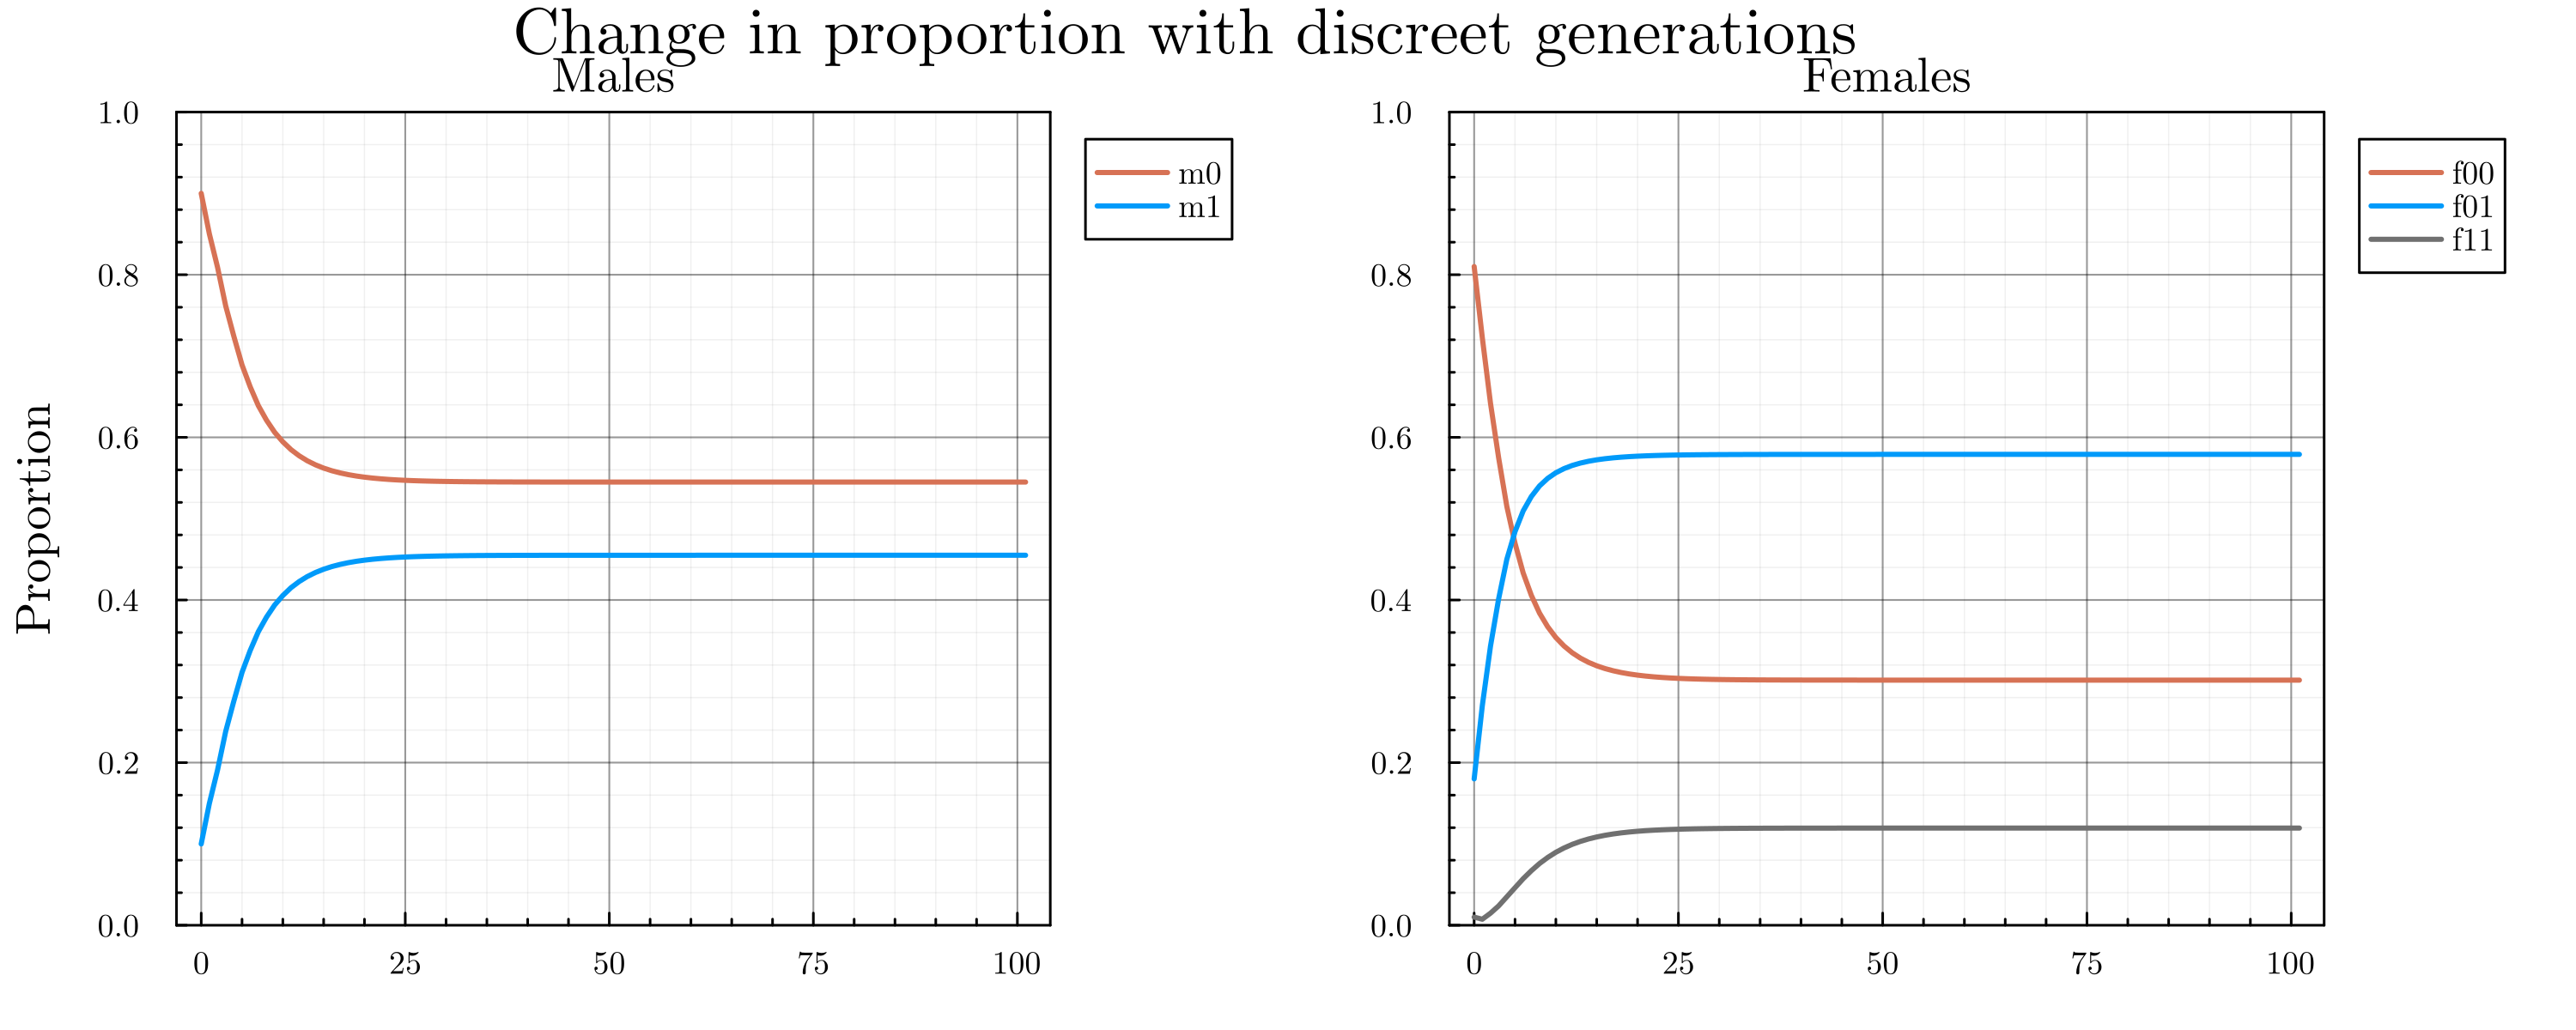

In [19]:
#Simulating proportions of each individual over a generation time
DOMINANT = true   #This simulation is for the recessive case
SHAPE = "linear"      #Shape for the survival function being used is exponential
gentime = 100

param = copy(P)    #Copying the main param dictionary to avoid making any changes to it
param["pm"] = 0.1
param["pf"] = 0.1

param["c_f"] = 0.65
param["c_m"] = 0.65

param["u"] = 0.05
param["r"] = 0.4737

females = []
males = []

ind_prop = Dict(      #Dictionary storing the proportion of indivduals at each generation
    "m0" => [1 - param["pm"]],
    "m1" => [param["pm"]],
    
    "f00" => [(1 - param["pf"])^2],
    "f01" => [param["pf"] * (1 - param["pf"]) * 2],
    "f11" => [param["pf"]^2],
    )

for t in 0:gentime
    female_ls, male_ls = nexgen(param, females, males)

    push!(ind_prop["m0"], male_ls[1] / sum(male_ls))
    push!(ind_prop["m1"], male_ls[2] / sum(male_ls))

    push!(ind_prop["f00"], female_ls[1] / sum(female_ls))
    push!(ind_prop["f01"], female_ls[2] / sum(female_ls))
    push!(ind_prop["f11"], female_ls[3] / sum(female_ls))

    females = female_ls ./ sum(female_ls)
    males = male_ls ./ sum(male_ls)
end


rng = collect(0:gentime+1)
p1 = plot(rng, [ind_prop["m0"] ind_prop["m1"]], labels = ["m0" "m1"], lw = 2, ylabel = "Proportion", title = "Males", xlabel = "", ylimits=[0,1])
p2 = plot(rng, [ind_prop["f00"] ind_prop["f01"] ind_prop["f11"]], labels = ["f00" "f01" "f11"], lw = 2, title = "Females", xlabel = "", ylimits=[0,1])
p3 = plot(rng, [ind_prop["m0"] ind_prop["m1"]], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations", ylabel = "Proportion")
prec = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"]) ind_prop["f11"]], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")
pdom = plot(rng, [ind_prop["f00"] (ind_prop["f01"] .+ ind_prop["f11"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")

plot(p1, p2, layout = (1,2), size = (1000,400), plot_title = string("Change in proportion with discreet generations"), left_margin = 5mm, bottom_margin = 5mm, right_margin = 5mm,dpi=300)

#=The plots in order:
[[Proportion of all male genotypes; Proportion of all female genotypes]
 [Proportion of defenders in males; Proportion of defenders in females]]
=#

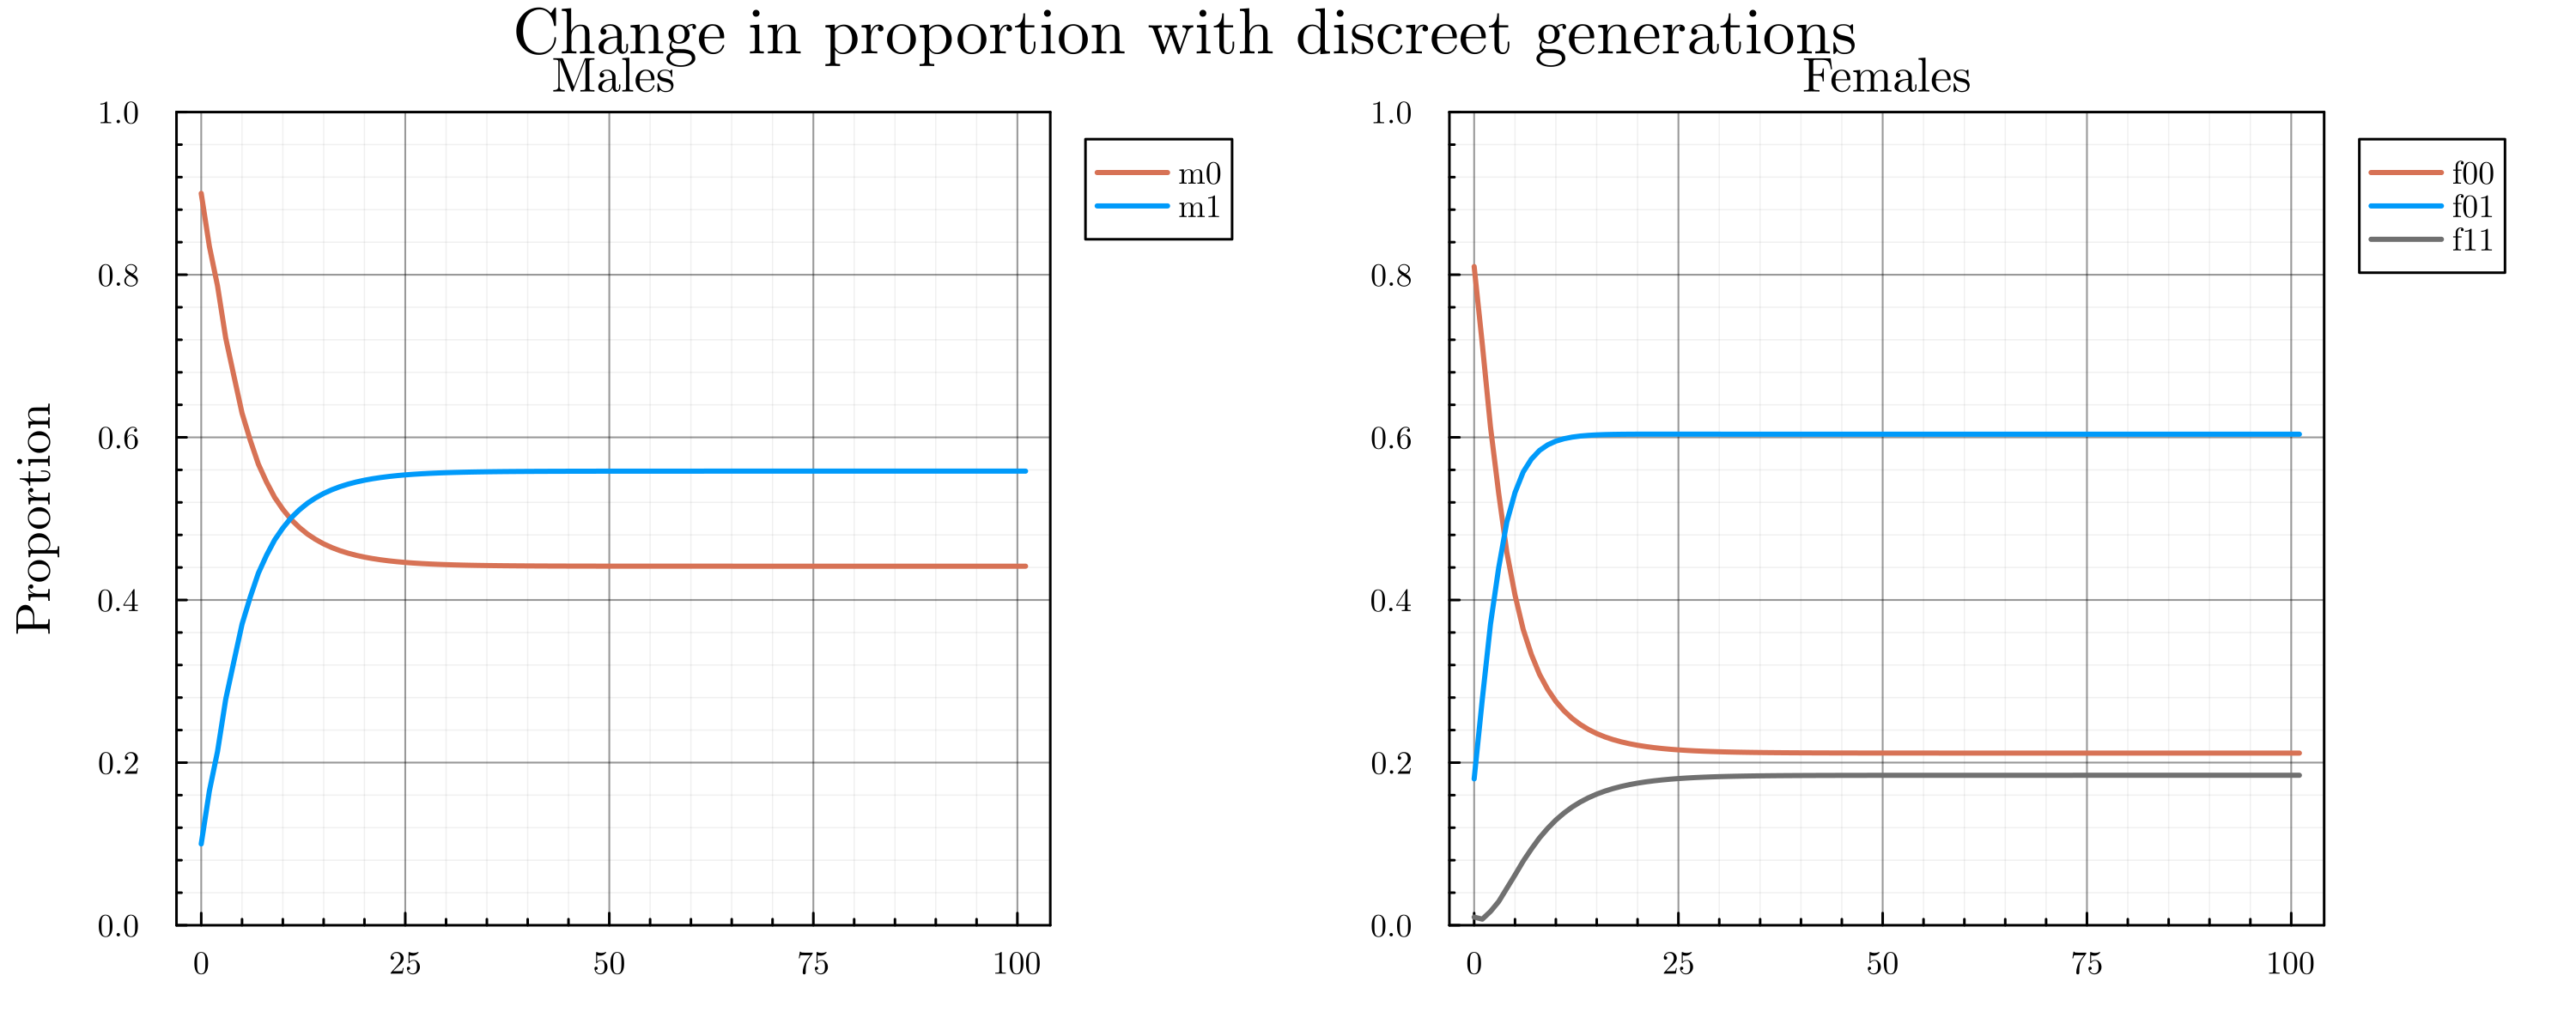

In [16]:
#Simulating proportions of each individual over a generation time
DOMINANT = true   #This simulation is for the recessive case
SHAPE = "linear"      #Shape for the survival function being used is exponential
gentime = 100

param = copy(P)    #Copying the main param dictionary to avoid making any changes to it
param["pm"] = 0.1
param["pf"] = 0.1

param["c_f"] = 0.65
param["c_m"] = 0.65

param["u"] = 0.05
param["r"] = 0.4737

females = []
males = []

ind_prop = Dict(      #Dictionary storing the proportion of indivduals at each generation
    "m0" => [1 - param["pm"]],
    "m1" => [param["pm"]],
    
    "f00" => [(1 - param["pf"])^2],
    "f01" => [param["pf"] * (1 - param["pf"]) * 2],
    "f11" => [param["pf"]^2],
    )

for t in 0:gentime
    female_ls, male_ls = nexgen(param, females, males)

    push!(ind_prop["m0"], male_ls[1] / sum(male_ls))
    push!(ind_prop["m1"], male_ls[2] / sum(male_ls))

    push!(ind_prop["f00"], female_ls[1] / sum(female_ls))
    push!(ind_prop["f01"], female_ls[2] / sum(female_ls))
    push!(ind_prop["f11"], female_ls[3] / sum(female_ls))

    females = female_ls ./ sum(female_ls)
    males = male_ls ./ sum(male_ls)
end


rng = collect(0:gentime+1)
p1 = plot(rng, [ind_prop["m0"] ind_prop["m1"]], labels = ["m0" "m1"], lw = 2, ylabel = "Proportion", title = "Males", xlabel = "", ylimits=[0,1])
p2 = plot(rng, [ind_prop["f00"] ind_prop["f01"] ind_prop["f11"]], labels = ["f00" "f01" "f11"], lw = 2, title = "Females", xlabel = "", ylimits=[0,1])
p3 = plot(rng, [ind_prop["m0"] ind_prop["m1"]], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations", ylabel = "Proportion")
prec = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"]) ind_prop["f11"]], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")
pdom = plot(rng, [ind_prop["f00"] (ind_prop["f01"] .+ ind_prop["f11"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")

plot(p1, p2, layout = (1,2), size = (1000,400), plot_title = string("Change in proportion with discreet generations"), left_margin = 5mm, bottom_margin = 5mm, right_margin = 5mm,dpi=300)

#=The plots in order:
[[Proportion of all male genotypes; Proportion of all female genotypes]
 [Proportion of defenders in males; Proportion of defenders in females]]
=#

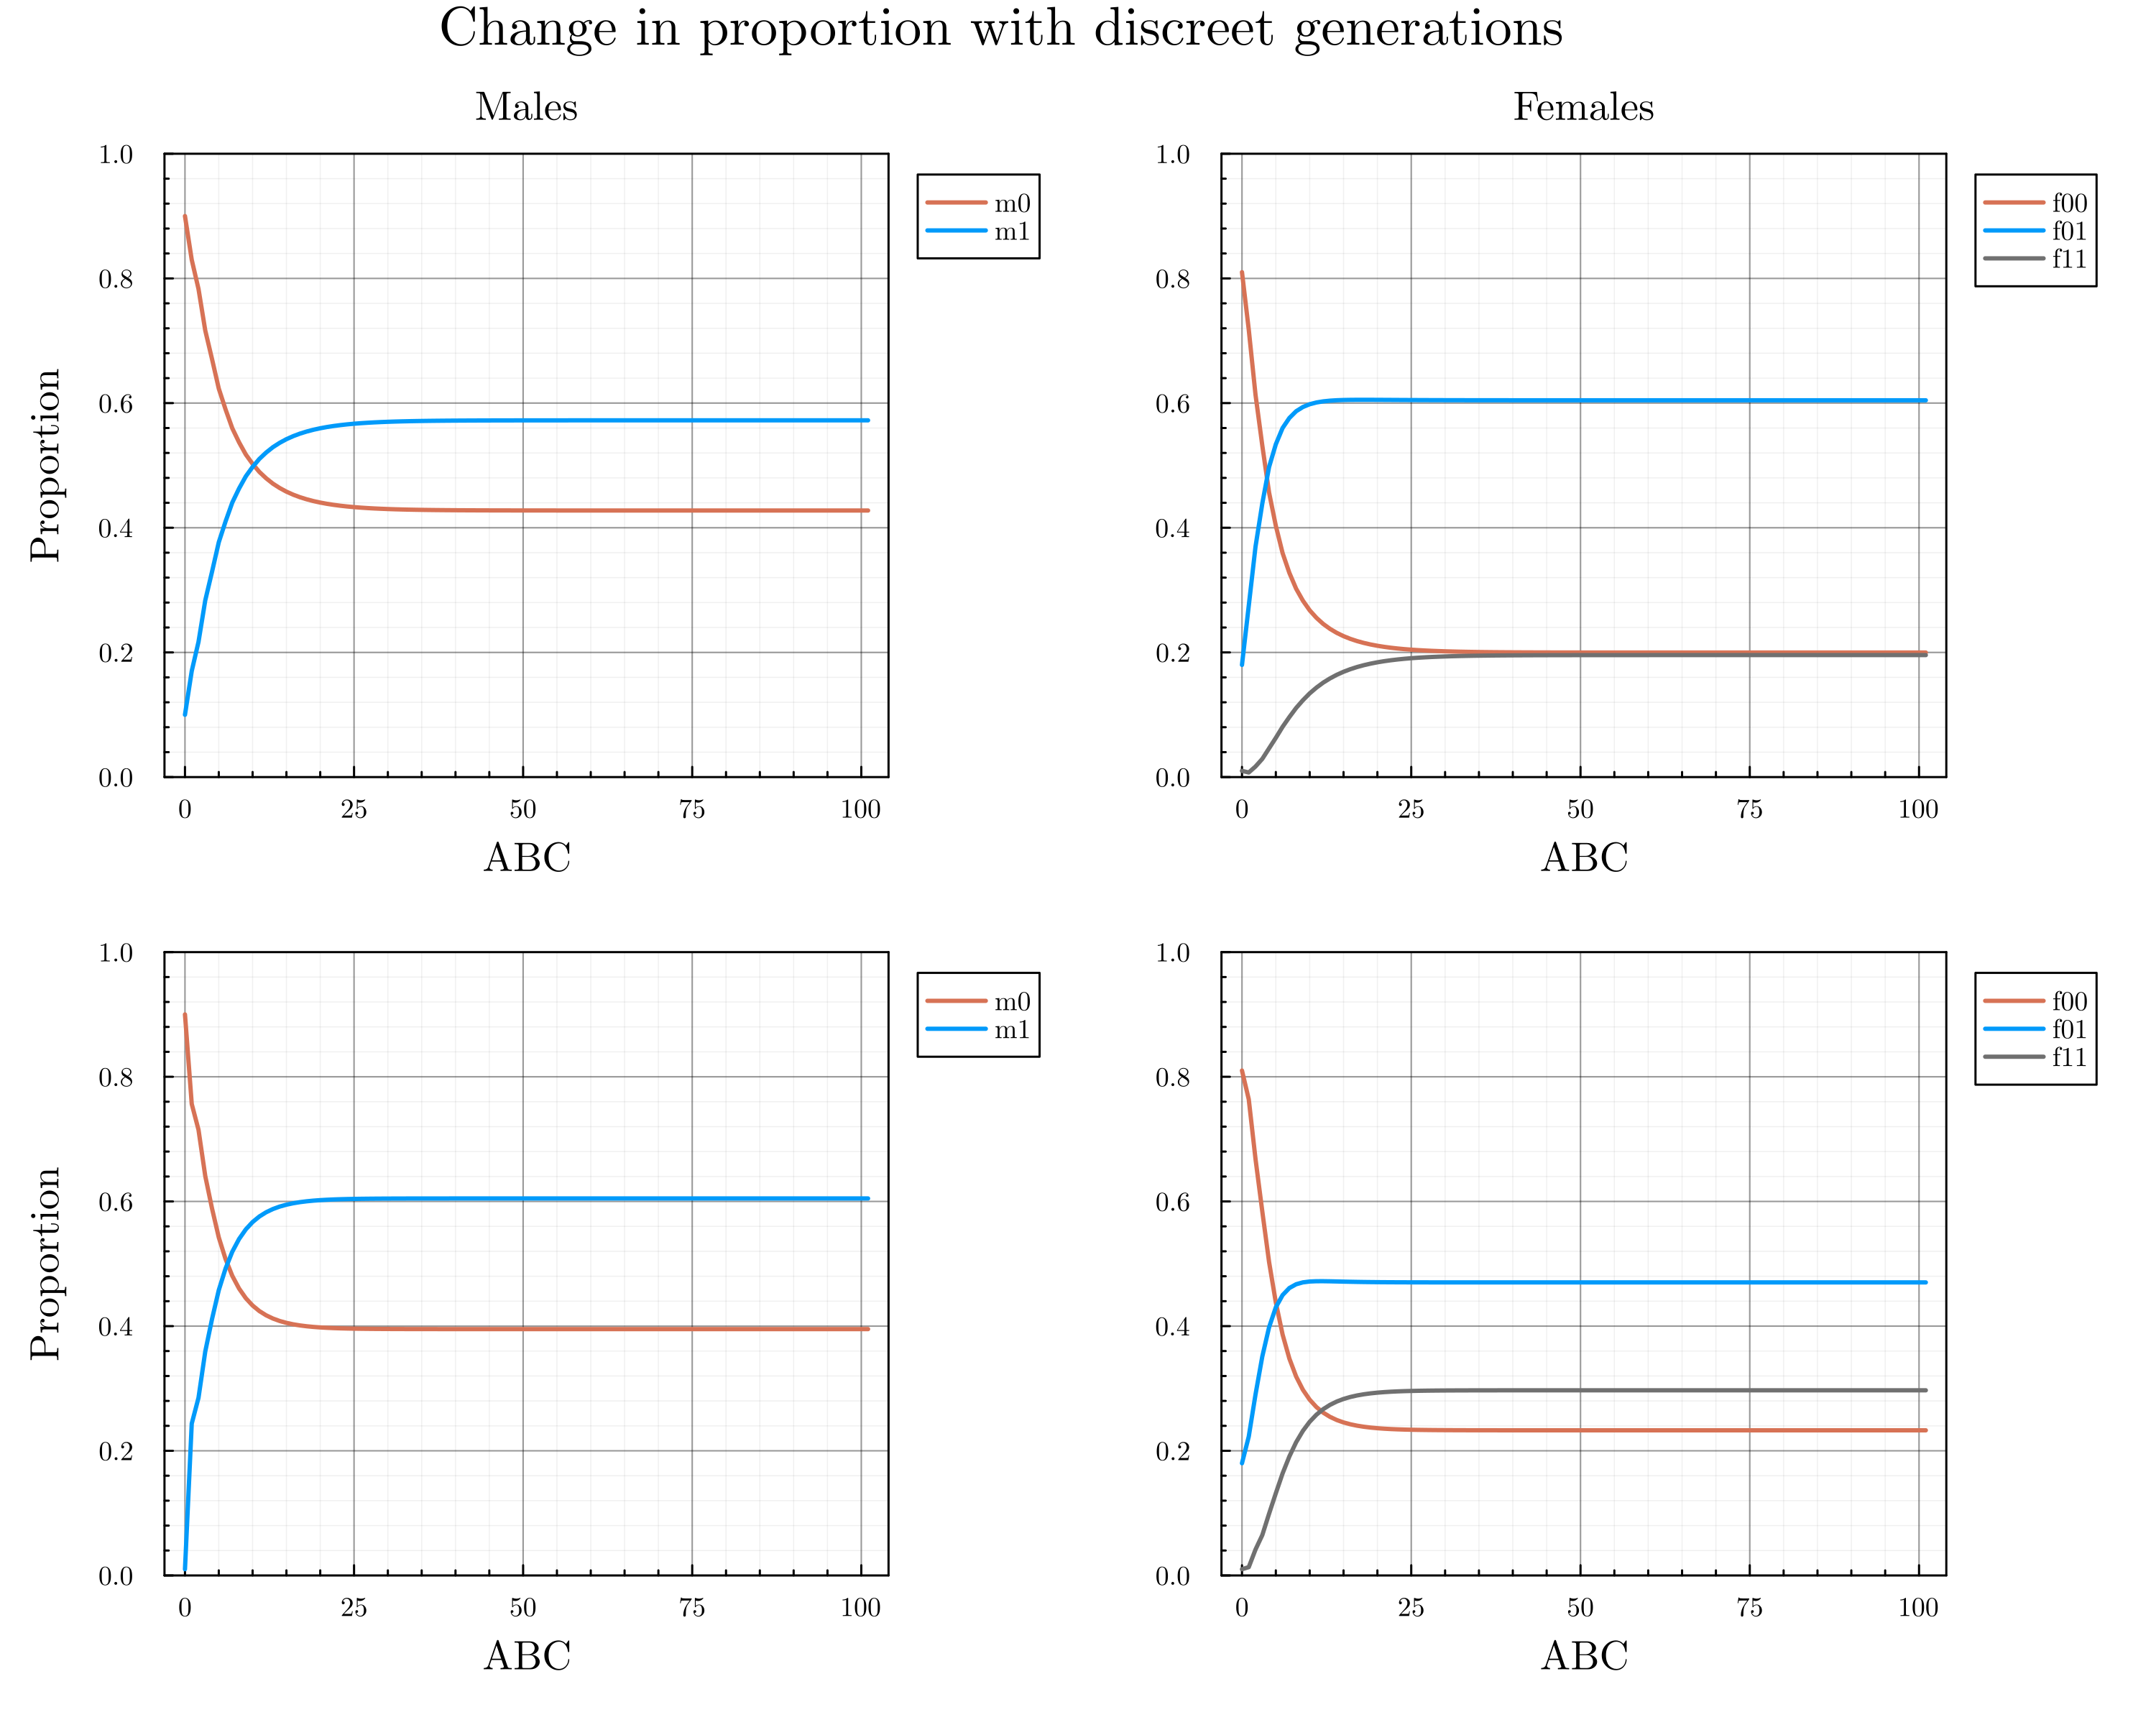

In [19]:
#Simulating proportions of each individual over a generation time
DOMINANT = false   #This simulation is for the recessive case
SHAPE = "linear"      #Shape for the survival function being used is exponential
gentime = 100

param = copy(P)    #Copying the main param dictionary to avoid making any changes to it
param["pm"] = 0.1
param["pf"] = 0.1

param["c_f"] = 0.65
param["c_m"] = 0.65

param["u"] = 0.05
param["r"] = 0.4737

females = []
males = []

ind_prop = Dict(      #Dictionary storing the proportion of indivduals at each generation
    "m0" => [1 - param["pm"]],
    "m1" => [P["pm"]],
    
    "f00" => [(1 - param["pf"])^2],
    "f01" => [param["pf"] * (1 - param["pf"]) * 2],
    "f11" => [param["pf"]^2],
    )

for t in 0:gentime
    female_ls, male_ls = nexgen(param, females, males)

    push!(ind_prop["m0"], male_ls[1] / sum(male_ls))
    push!(ind_prop["m1"], male_ls[2] / sum(male_ls))

    push!(ind_prop["f00"], female_ls[1] / sum(female_ls))
    push!(ind_prop["f01"], female_ls[2] / sum(female_ls))
    push!(ind_prop["f11"], female_ls[3] / sum(female_ls))

    females = female_ls ./ sum(female_ls)
    males = male_ls ./ sum(male_ls)
end


rng = collect(0:gentime+1)
p4 = plot(rng, [ind_prop["m0"] ind_prop["m1"]], labels = ["m0" "m1"], lw = 2, ylabel = "Proportion", title = "", xlabel = "Generations", ylimits=[0, 1])
p5 = plot(rng, [ind_prop["f00"] ind_prop["f01"] ind_prop["f11"]], labels = ["f00" "f01" "f11"], lw = 2, title = "", xlabel = "Generations", ylimits=[0, 1])
p3 = plot(rng, [ind_prop["m0"] ind_prop["m1"]], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations", ylabel = "Proportion")
prec = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"]) ind_prop["f11"]], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")
pdom = plot(rng, [ind_prop["f00"] (ind_prop["f01"] .+ ind_prop["f11"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")

final = plot(p1, p2, p4, p5, layout = (2,2), size = (1000,800), plot_title = string("Change in proportion with discreet generations"),xlabel = "ABC", left_margin = 5mm, bottom_margin = 5mm, right_margin = 5mm,dpi=300)
#savefig(final, string("C:/project/Masters_2023_DrHannaK/outputs/","test.png"))
#=The plots in order:
[[Proportion of all male genotypes; Proportion of all female genotypes]
 [Proportion of defenders in males; Proportion of defenders in females]]
=#

In [ ]:
final = plot(p1,p2,p4,p5, layout=(2,2), size = (1000,800), plot_title = string("Change in proportion with discreet generations"), left_margin = 5mm, bottom_margin = 5mm, right_margin = 5mm,dpi=300)
savefig(final, string("C:/project/Masters_2023_DrHannaK/outputs/","BM_defdyn_lin_u1r5cf65cm65.png"))

In [15]:
function prop_plot(P) #Function to produce dataframes of defender proportion with varying costs (c and alpha)
    range_cost = round.(collect(range(0, 1, 21)), digits = 2)

    param = copy(P)
    param["pm"] = 0.1
    param["pf"] = 0.1

    param["u"] = 0.05
    param["r"] = 0.6474    

    gentime = 200

    female_data = DataFrame([name => zeros(Float64, size(range_cost,1)) for name in string.(1:size(range_cost,1))])
    male_data = DataFrame([name => zeros(Float64, size(range_cost,1)) for name in string.(1:size(range_cost,1))])
    total_data = DataFrame([name => zeros(Float64, size(range_cost,1)) for name in string.(1:size(range_cost,1))])

    for i in 1:size(range_cost,1)

        param["c_f"] = range_cost[i]

        #Calculating combinations
        param["comb_f01"] = DOMINANT ? calc_combinations(int((1-param["c_f"])*param["B"]), 2, 1, [0.5, 0.5]) : calc_combinations(param["B"], 2, 1, [0.5, 0.5])

        param["comb_f00m0"] = calc_combinations(param["B"], 2, 0, [1-param["r"], param["r"]])

        param["comb_f11m1"] = calc_combinations(int((1-param["c_f"])*param["B"]), 2, 2, [1-param["r"], param["r"]])

        param["comb_f00m1"] = DOMINANT ? calc_combinations(param["B"], 2, 1, [1 - param["r"], param["r"]]) : calc_combinations(param["B"], 2, 0, [1 - param["r"], param["r"]])

        param["comb_f11m0"] = DOMINANT ? calc_combinations(int((1-param["c_f"])*param["B"]), 2, 2, [param["r"], 1 - param["r"]]) : calc_combinations(int((1-param["c_f"])*param["B"]), 2, 1, [param["r"], 1 - param["r"]])

        param["comb_f01m0"] = DOMINANT ? calc_combinations(int((1-param["c_f"])*param["B"]), 4, 2, [param["r"] * 0.5, (1 - param["r"]) * 0.5, param["r"] * 0.5, (1 - param["r"]) * 0.5]) : calc_combinations(param["B"], 4, 1, [param["r"] * 0.5, (1 - param["r"]) * 0.5, param["r"] * 0.5, (1 - param["r"]) * 0.5])

        param["comb_f01m1"] = DOMINANT ? calc_combinations(int((1-param["c_f"])*param["B"]), 4, 3, [(1 - param["r"]) * 0.5, param["r"] * 0.5, (1 - param["r"]) * 0.5, param["r"] * 0.5]) : calc_combinations(param["B"], 4, 2, [(1 - param["r"]) * 0.5, param["r"] * 0.5, (1 - param["r"]) * 0.5, param["r"] * 0.5])


        for j in 1:size(range_cost,1)
            param["c_m"] = range_cost[j]

            females = []
            males = []
            
            female_ls = []
            male_ls = []
            for t in 0:gentime
                females, males = nexgen(param, female_ls, male_ls)

                female_ls = copy(females)
                male_ls = copy(males)

                female_ls = female_ls ./ (sum(female_ls))
                male_ls = male_ls ./ (sum(male_ls))
            end
                    
            if DOMINANT
                total_def = (males[2] + sum(females[2:end])) / (sum(males) + sum(females))
                male_def = males[2] / sum(males)
                female_def = sum(females[2:end]) / sum(females)
            else
                total_def = (males[2] + females[3]) / (sum(males) + sum(females))
                male_def = males[2] / sum(males)
                female_def = females[3] / sum(females)
            end
                
            female_data[j,i] = female_def
            male_data[j,i] = male_def
            total_data[j,i] = total_def
        
        end
    
    end

    return female_data, male_data, total_data
end

prop_plot (generic function with 1 method)

In [16]:
shapes = ["s", "linear", "exp", "expinv"] #Running the function through all shapes and for both dominant and recessive cases, saving the output as csv
filepath = "C:/project/Masters_2023_DrHannaK/DataCSVs/multinomial/"

@showprogress 1 "Computing..." for i in 1:4
    SHAPE = shapes[i]
    DOMINANT = true
    f_dom, m_dom, t_dom = prop_plot(P)
    DOMINANT = false
    f_rec, m_rec, t_rec = prop_plot(P)

    CSV.write(string(filepath, "BM_f_dom_u05r6474_", SHAPE,".csv"), f_dom)
    CSV.write(string(filepath, "BM_m_dom_u05r6474_", SHAPE,".csv"), m_dom)
    CSV.write(string(filepath, "BM_t_dom_u05r6474_", SHAPE,".csv"), t_dom)
    CSV.write(string(filepath, "BM_f_rec_u05r6474_", SHAPE,".csv"), f_rec)
    CSV.write(string(filepath, "BM_m_rec_u05r6474_", SHAPE,".csv"), m_rec)
    CSV.write(string(filepath, "BM_t_rec_u05r6474_", SHAPE,".csv"), t_rec)
end

Computing... 100%|███████████████████████████████████████| Time: 0:00:08


In [ ]:
c_f = round.(collect(range(0, 1, 21)), digits = 2)
B = 20
print(int.((1 .- c_f) .* B))
#[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 3, 3, 1, 1, 0]

In [44]:
range_c = collect(0:1:20)

21-element Vector{Int64}:
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
  ⋮
 12
 13
 14
 15
 16
 17
 18
 19
 20